# Paint with Generative Adversarial Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, losses, optimizers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

replicas = strategy.num_replicas_in_sync
autotune = tf.data.experimental.AUTOTUNE

### Problem

This project is about generating imitated artworks with generative adversarial networks (GANs). A GAN consists of a generator model and a discriminator model. The generator model is a neural network that creates the images and the discriminator model is used to train the generator model. The two models works against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images. In this project, we will build a GAN that generates 7,000 to 10,000 Monet-style images.

## Data

In [3]:
gcs_path = KaggleDatasets().get_gcs_path('gan-getting-started')

monet_filenames = tf.io.gfile.glob(str(gcs_path + '/monet_tfrec/*.tfrec'))
photo_filenames = tf.io.gfile.glob(str(gcs_path + '/photo_tfrec/*.tfrec'))
print('Monet Files: ', len(monet_filenames))
print('Photo Files: ', len(photo_filenames))

Monet Files:  5
Photo Files:  20


In [4]:
# According to the information from the competition overview page,
# the images are sized to 256x256, so the weight and the height would be 256.
# The channel would be 3 as the images are RGB images.

height = 256
width = 256
channels = 3

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=channels)
    image = (tf.cast(image, tf.float32)/127.5)-1
    image = tf.reshape(image, [height, width, channels])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)}
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=autotune)
    return dataset

### Sample Monet Paintings

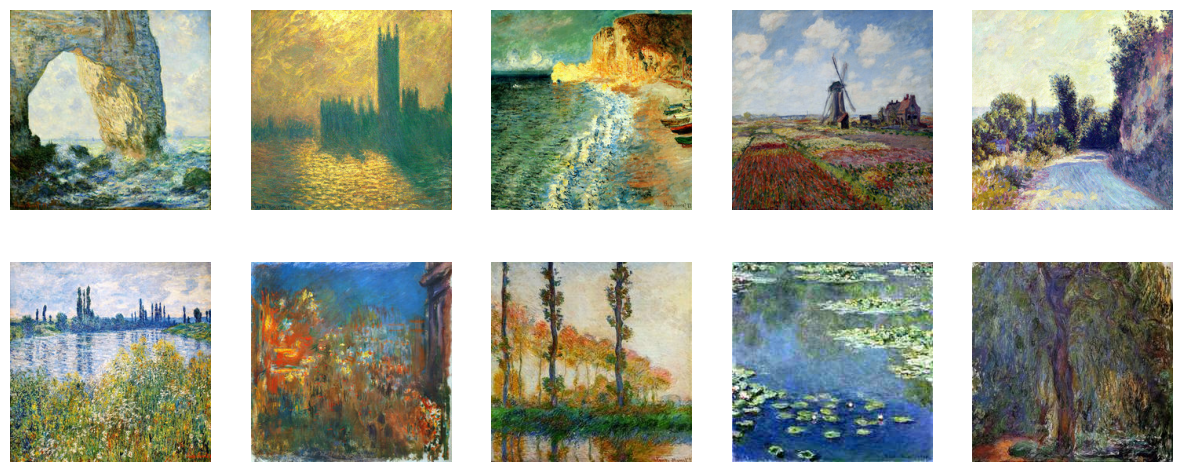

In [5]:
def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.show()

display_samples(load_dataset(monet_filenames).batch(1), 2, 5)

### Downsample and Upsample

In [6]:
# Produce the abstract representations of the input images

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, padding='same',
                        kernel_initializer=initializer, use_bias=False))
    result.add(layers.MaxPool2D())
    
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result


# Make the reduced spatial dimensions equal to the input images

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                 kernel_initializer=initializer, use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

## Generator Model

In [7]:
# Sample, reshape, downsample and Upsample

def generator():
    inputs = layers.Input(shape=[height,width,channels])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0.,0.02)
    last = layers.Conv2DTranspose(3,4,strides=2,padding='same', kernel_initializer=initializer,activation='tanh')

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    x = last(x)

    return Model(inputs=inputs, outputs=x)

## Discriminator Model

In [8]:
# Classify the input images

def discriminator():
    initializer = tf.random_normal_initializer(0.,0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[height,width,channels], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last_conv = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return Model(inputs=inp, outputs=last_conv)

## Build a GAN

In [9]:
with strategy.scope():
    monet_generator = generator()
    photo_generator = generator()
    monet_discriminator = discriminator()
    photo_discriminator = discriminator()


class gan(Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10):
        super(gan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(gan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {'monet_gen_loss': total_monet_gen_loss, 'photo_gen_loss': total_photo_gen_loss,
                'monet_disc_loss': monet_disc_loss, 'photo_disc_loss': photo_disc_loss}

### Loss Function

In [10]:
with strategy.scope():
    def discriminator_loss(real, generated):
        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5
    
    def generator_loss(generated):
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    with strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
            return LAMBDA * loss1

    with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return LAMBDA * 0.5 * loss

## Train the Model

In [11]:
def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)

    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(autotune)
    photo_ds = photo_ds.prefetch(autotune)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

with strategy.scope():
    monet_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
    
    gan_model = gan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

    gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                      p_gen_optimizer=photo_generator_optimizer,
                      m_disc_optimizer=monet_discriminator_optimizer,
                      p_disc_optimizer=photo_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)
    
history = gan_model.fit(get_gan_dataset(monet_filenames, photo_filenames, batch_size=1), 
                        steps_per_epoch=300, epochs=5, verbose=2).history

Epoch 1/5
300/300 - 2473s - monet_gen_loss: 4.3529 - photo_gen_loss: 4.4531 - monet_disc_loss: 0.5446 - photo_disc_loss: 0.2312 - 2473s/epoch - 8s/step
Epoch 2/5
300/300 - 2320s - monet_gen_loss: 4.5374 - photo_gen_loss: 4.8766 - monet_disc_loss: 0.3786 - photo_disc_loss: 0.3426 - 2320s/epoch - 8s/step
Epoch 3/5
300/300 - 2325s - monet_gen_loss: 4.3340 - photo_gen_loss: 3.5699 - monet_disc_loss: 0.5209 - photo_disc_loss: 1.3192 - 2325s/epoch - 8s/step
Epoch 4/5
300/300 - 2331s - monet_gen_loss: 3.5575 - photo_gen_loss: 3.6422 - monet_disc_loss: 0.4502 - photo_disc_loss: 0.5430 - 2331s/epoch - 8s/step
Epoch 5/5
300/300 - 2358s - monet_gen_loss: 3.7631 - photo_gen_loss: 3.5654 - monet_disc_loss: 0.5823 - photo_disc_loss: 0.9449 - 2358s/epoch - 8s/step


## Prediction

1/1 [==============================] - 1s 1s/step


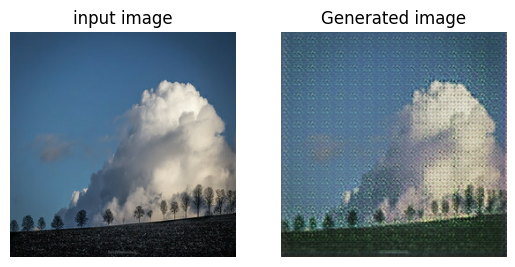

1/1 [==============================] - 0s 317ms/step


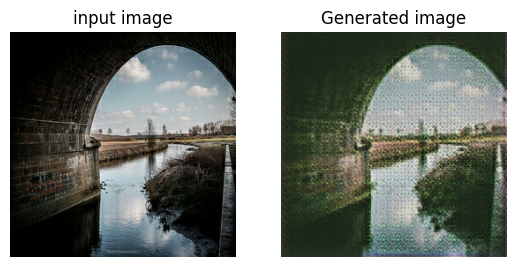

1/1 [==============================] - 0s 312ms/step


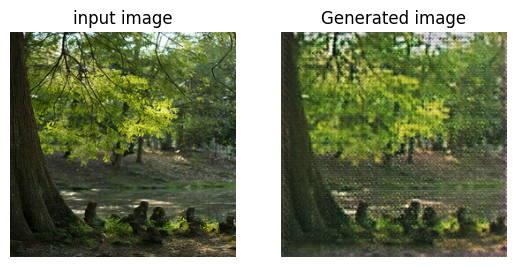

1/1 [==============================] - 0s 320ms/step


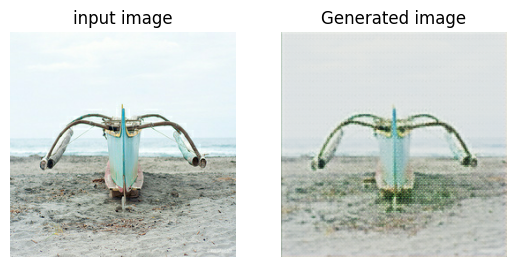

1/1 [==============================] - 0s 312ms/step


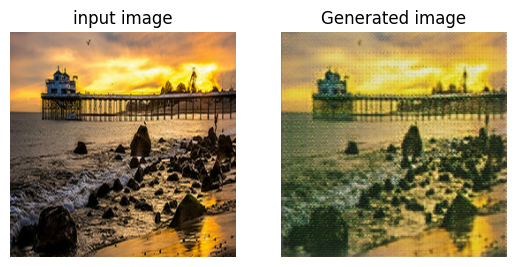

1/1 [==============================] - 0s 314ms/step


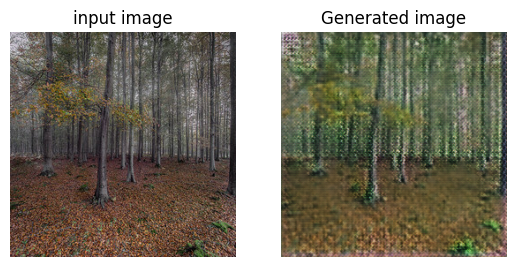

1/1 [==============================] - 0s 333ms/step


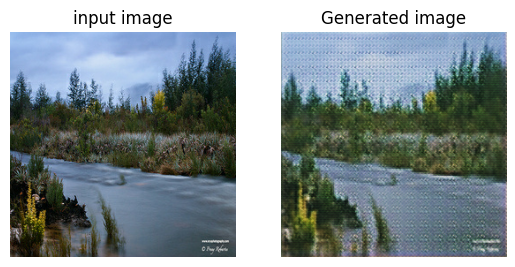

1/1 [==============================] - 0s 315ms/step


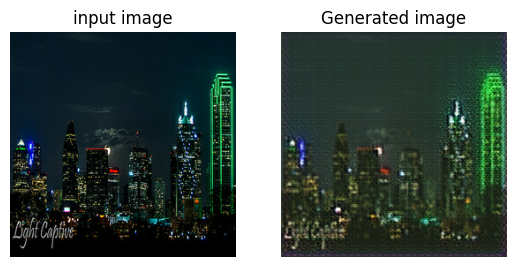

In [12]:
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        plt.subplot(121)
        plt.title("input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

display_generated_samples(load_dataset(photo_filenames).batch(1), monet_generator, 8)

In [17]:
import os
from PIL import Image

os.makedirs('../images/', exist_ok=True)

def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        im = Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

predict_and_save(load_dataset(photo_filenames).batch(1), monet_generator, '../images/')

## Make a Submission

In [19]:
import shutil
shutil.make_archive('/kaggle/working/images/', 'zip', '../images')

print(f"Generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

Generated samples: 7038


## Conclusion and Discussion

In this project, we generated artworks with Generative Adversarial Networks.
Firstly, we imported the packages needed and changed the accelerator to TPU. The dataset we used for the project was Monet dataset and Photo dataset for the Cycle GAN. With the loaded datasets, we displayed some sample images to see.
After setting the functions of downsampling and upsampling, we built the generator and the discriminator. Then a GAN was built and trained.
Finally we made predictions -generating images- with the model and saved them.

Since this was the first experience of generating images with GAN, it was not easy to proceed smoothly or make it with high quality. In particular, it would have resulted better if we used a larger number of epochs in the process of training the model. However, the fact that a trained model can generate those artworks is great, and it is quite encouraging that it can do more than that.